# ML Rank Histograms

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


Input a file path

In [2]:
source_path = "/home/florianb/havvarsel/multilevelDA/scripts/RankHistograms/ML/2023-10-13T12_07_24"

See the files in the directory

In [3]:
exp_ns = []
for f in os.listdir(source_path):
    if f not in ["log.txt", "script_copy.py"]:
        exp_ns.append(int(f.split("_")[0]))

exp_ns = np.array(list(set(exp_ns)))

In [4]:
n = 0

n_files = []
for f in os.listdir(source_path):
    if f.startswith(str(n)+"_"):
        n_files.append(f)

In [5]:
l_max = int((len(n_files)-2)/2)

In [6]:
n_files

['0_MLstate_3_0.npy',
 '0_MLstate_2_1.npy',
 '0_MLstate_2_0.npy',
 '0_MLstate_1_1.npy',
 '0_MLstate_0.npy',
 '0_truth.npy',
 '0_MLstate_1_0.npy',
 '0_MLstate_3_1.npy']

In [7]:
np.load(source_path+"/0_MLstate_3_0.npy").shape

(3, 512, 6)

Load ensemble and truth per experiment from file

In [8]:
def loadMLline(source_path, n):
    n_files = []
    for f in os.listdir(source_path):
        if f.startswith(str(n)+"_"):
            n_files.append(f)
    l_max = int((len(n_files)-2)/2)

    MLensemble = []
    MLensemble.append(np.load([source_path+"/"+f for f in n_files if f.endswith("_MLstate_0.npy")][0]))
    for l_idx in range(1, l_max+1):
        MLensemble.append([np.load([source_path+"/"+f for f in n_files if f.endswith("_MLstate_"+str(l_idx)+"_0.npy")][0]),
                           np.load([source_path+"/"+f for f in n_files if f.endswith("_MLstate_"+str(l_idx)+"_1.npy")][0])])
    return MLensemble

In [9]:
MLensemble = loadMLline(source_path, 0)

In [10]:
def loadTruth(source_path, n):
    return np.load(source_path+"/"+str(n)+"_truth.npy")

In [11]:
truth = loadTruth(source_path, 0)

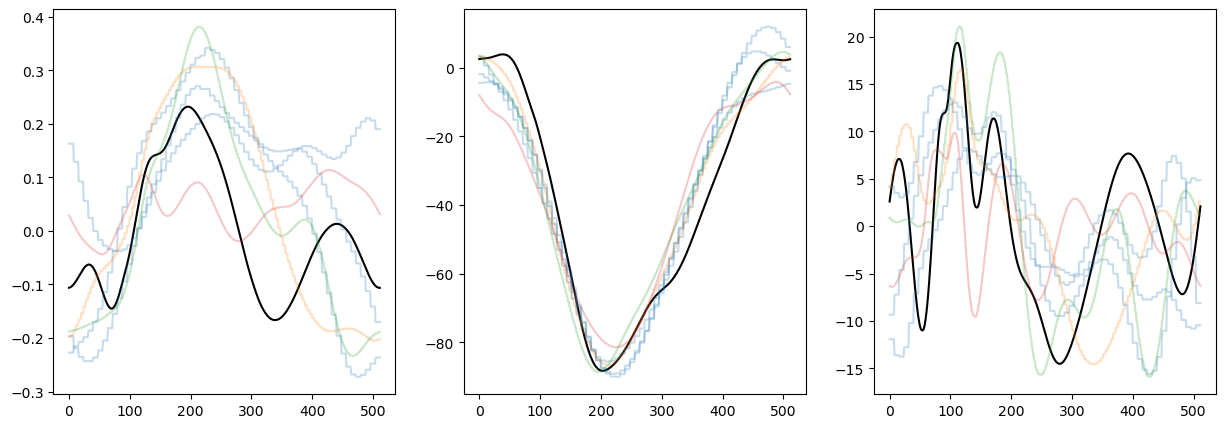

In [12]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

for i in range(3):
    axs[i].plot(truth[i], c="black")

    for e in range(len(MLensemble[0])):
        axs[i].plot(MLensemble[0][i,:,e].repeat(2**l_max), c="C0", alpha=0.25)

    for l_idx in range(1,l_max+1):
        axs[i].plot(MLensemble[l_idx][0][i,:,e].repeat(2**(l_max-l_idx)), c="C"+str(l_idx), alpha=0.25)

Define evaluation locations along the line 

In [13]:
fine_obs_idxs = np.arange(64, 512, 64)

In [14]:
MLvar = np.std(MLensemble[0], axis=-1).repeat(2**l_max, 1)
for l_idx in range(1, l_max+1):
    MLvar += np.std(MLensemble[l_idx][0], axis=-1).repeat(2**(l_max-l_idx),1) \
            - np.std(MLensemble[l_idx][1], axis=-1).repeat(2**(l_max-l_idx+1),1)

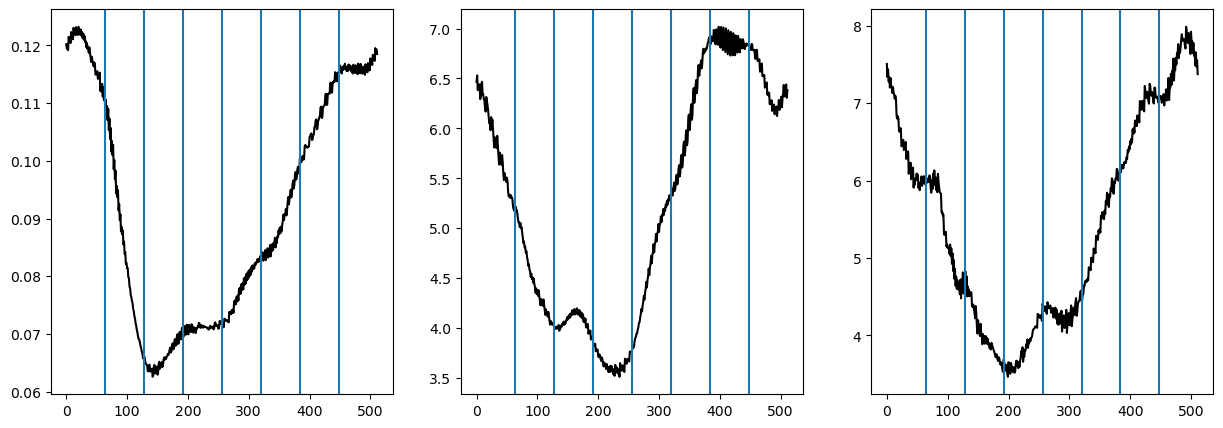

In [15]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    axs[i].plot(MLvar[i], c="black")
    for o in range(len(fine_obs_idxs)):
        axs[i].axvline(fine_obs_idxs[o])


In [16]:
obs_idxs4fine = []
for o in range(len(fine_obs_idxs)):
    obs_idxs = []
    for l_idx in range(l_max+1):
        obs_idxs.append( int(fine_obs_idxs[o]/(2**(l_max-l_idx))) )
    obs_idxs4fine.append(obs_idxs)

In [17]:
obs_idxs4fine

[[8, 16, 32, 64],
 [16, 32, 64, 128],
 [24, 48, 96, 192],
 [32, 64, 128, 256],
 [40, 80, 160, 320],
 [48, 96, 192, 384],
 [56, 112, 224, 448]]

Rank Histogram Utils

In [18]:
def MLrank(ensemble, truth, obs_idxs, R=None,
           func=lambda ensemble_values, true_values: 1*(ensemble_values < true_values)):
    # true reference
    true_value = truth[:,obs_idxs[-1]]
    if R is not None:
        true_value += np.random.normal(0, R)

    if not isinstance(func, list):
        func = len(ensemble)*[[func,func,func]]

    # level 0 
    ensemble_values = ensemble[0][:,obs_idxs[0]]
    if R is not None:
        ensemble_values += np.random.multivariate_normal(np.zeros(3), np.diag(R), size=ensemble_values.shape[-1]).T

    ML_Fy = np.zeros(3)
    for i in range(3):
        ML_Fy[i] = 1/ensemble_values.shape[-1]*np.sum(func[0][i](ensemble_values[i], true_value[i]))

    # higher levels
    for l_idx in range(1, len(ensemble)):
        ensemble_values0 = ensemble[l_idx][0][:,obs_idxs[l_idx]]
        ensemble_values1 = ensemble[l_idx][1][:,obs_idxs[l_idx-1]]

        if R is not None:
            lvl_perts = np.random.multivariate_normal(np.zeros(3), np.diag(R), size=len(ensemble_values0)).T
            ensemble_values0 += lvl_perts
            ensemble_values1 += lvl_perts

        for i in range(3):
            ML_Fy[i] += 1/ensemble_values0.shape[-1] * np.sum( func[l_idx][i](ensemble_values0[i], true_value[i]) 
                                                                - func[l_idx][i](ensemble_values1[i], true_value[i]) )
        
    return ML_Fy

In [80]:
def plot_histogram(ML_ranks, bins_size=1/25, xlim=(-0.25,1.25)):
    
    fig, axs = plt.subplots(1, 3, figsize=(15,3))
    # fig.suptitle(r"$\bf{ML ranks}$",y=1.1)

    axs[0].set_title(r"$\eta$", fontsize=16)
    axs[1].set_title(r"$hu$", fontsize=16)
    axs[2].set_title(r"$hv$", fontsize=16)

    bins = np.arange(xlim[0],xlim[1]+1e-9, bins_size)

    for i in range(3):
        ranks = np.maximum(xlim[0], ML_ranks[i])
        ranks = np.minimum(ranks, xlim[1])
        hist = np.histogram(ranks, bins=bins)
        
        axs[i].bar(0.5*(hist[1][1:]+hist[1][:-1]),hist[0]/len(ML_ranks[i])/bins_size, width=bins_size, color="C0")
        
        axs[i].set_ylim((0,1.5))
        axs[i].set_xlim(xlim)

        axs[i].plot([0,1],[1,1], color="black", ls="--", lw=3)

### Direct Evaluation

In [76]:
MLranks = np.zeros((3, len(exp_ns)*len(fine_obs_idxs)))

for en in range(len(exp_ns)):
    n = exp_ns[en]
    MLensemble = loadMLline(source_path, n)
    truth = loadTruth(source_path, n)
    for o in range(len(fine_obs_idxs)):
        MLranks[:,en*len(fine_obs_idxs)+o] = MLrank(MLensemble, truth, obs_idxs4fine[o])

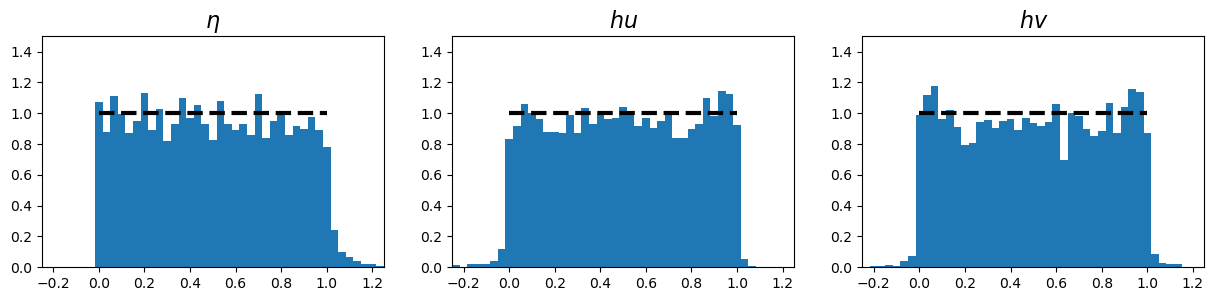

In [91]:
plot_histogram(MLranks, bins_size=1/30)

### Smoothed rank histograms

In [22]:
from scipy.stats import norm

In [94]:
eta_bws = np.array([0.005, 0.0075, 0.01, 0.0125])
huv_bws = np.array([0.75, 1, 1.25, 1.5])

funcs = []
for l_idx in range(l_max+1):
    funcs.append([lambda ensemble_values, true_value: 1 - norm.cdf(ensemble_values, loc=true_value, scale=eta_bws[l_idx]),
                 lambda ensemble_values, true_value: 1 - norm.cdf(ensemble_values, loc=true_value, scale=huv_bws[l_idx]),
                 lambda ensemble_values, true_value: 1 - norm.cdf(ensemble_values, loc=true_value, scale=huv_bws[l_idx])])


In [95]:
MLranks = np.zeros((3, len(exp_ns)*len(fine_obs_idxs)))

for en in range(len(exp_ns)):
    n = exp_ns[en]
    MLensemble = loadMLline(source_path, n)
    truth = loadTruth(source_path, n)
    for o in range(len(fine_obs_idxs)):
        MLranks[:,en*len(fine_obs_idxs)+o] = MLrank(MLensemble, truth, obs_idxs4fine[o], func=funcs)

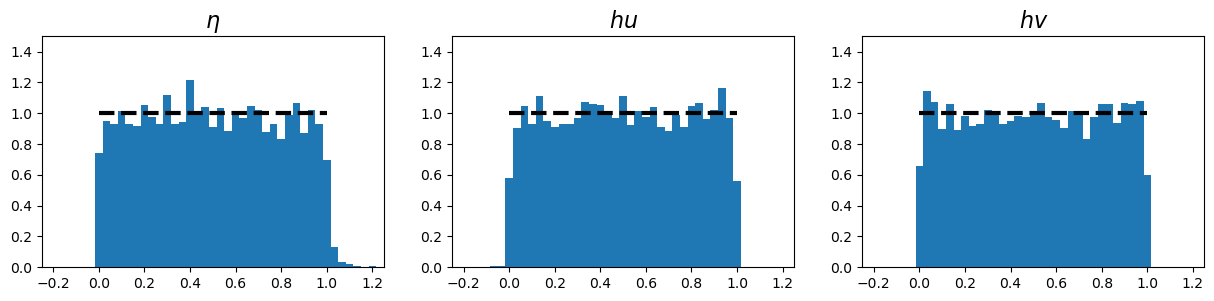

In [96]:
plot_histogram(MLranks, bins_size=1/30)

Maximal entropy

In [26]:
from scipy.special import eval_legendre

In [27]:
def maximal_entropyML(MLensemble, i, obs_idxs,
                    basis=lambda n, x: eval_legendre(n,x), 
                    N=3, 
                    x=np.linspace(-1,1,10001,endpoint=True)):
    """
    x has to be a symmetric array including both-sided end points and 0 in the middle!
    """
    
    scale_fac = x[-1]
    scaled_x = x/scale_fac

    scaledMLensemble = []

    scaledMLensemble.append(MLensemble[0][i]/scale_fac)
    for l in range(1, len(MLensemble)):
        scaledMLensemble.append([MLensemble[l][0][i]/scale_fac, MLensemble[l][1][i]/scale_fac])

    lm0 = np.zeros(N)
    lm0[0] = np.log(1/2) # 1/(xmax-xmin)  

    # Constructor for approximation
    def _construct_phi(lm, scaled_x):
        phi_exp = np.zeros(len(scaled_x)-1)
        for n in range(len(lm)):
            phi_exp += lm[n]*basis(n,((scaled_x[1:]+scaled_x[:-1])/2))

        return np.exp(phi_exp)
     
    # Helper functions for Newton solver
    def _est_mu(n, scaledMLensemble):
        mu = np.mean(basis(n, scaledMLensemble[0][obs_idxs[0]]))
        for l in range(1, len(scaledMLensemble)):
            mu += np.mean(basis(n, scaledMLensemble[l][0][obs_idxs[l]])) - np.mean(basis(n, scaledMLensemble[l][1][obs_idxs[l-1]])) 
        return mu
    
    mus = [_est_mu(n, scaledMLensemble) for n in range(N)]
    
    def _residual(mus, phi, scaled_x):
        scaled_dx = scaled_x[1]-scaled_x[0]
            
        F = np.zeros(len(mus))
        for n in range(len(mus)):
            F[n] = np.sum(basis(n, ((scaled_x[1:]+scaled_x[:-1])/2))*phi*scaled_dx) - mus[n]
        
        return F
    
    def _get_invJacobian(N, scaled_x, phi):
        scaled_dx = scaled_x[1]-scaled_x[0]
        
        J = np.zeros((N, N))
        for i in range(N):
            for j in range(i+1):
                J[i,j] = np.sum(basis(i,((scaled_x[1:]+scaled_x[:-1])/2))*basis(j, ((scaled_x[1:]+scaled_x[:-1])/2))*phi*scaled_dx)
                J[j,i] = J[i,j]

        return np.linalg.inv(J)
    
    # Solver
    def _newton(lm0, scaled_x, mus):
        lm = lm0
        converged = False

        for iter in range(20):

            phi = _construct_phi(lm, scaled_x)
            Jinv = _get_invJacobian(len(lm), scaled_x, phi)
            F = _residual(mus, phi, scaled_x)

            lm_delta = Jinv@F
            lm = lm - lm_delta

            # print(np.linalg.norm(lm_delta))
            if np.linalg.norm(lm_delta) < 1e-6:
                converged = True
                break
        
        return lm, converged
    
    lm, converged = _newton(lm0, scaled_x, mus)
    
    if converged:
        # Post processing
        def _cdf4lm(lm, scaled_x):
            scaled_dx = scaled_x[1]-scaled_x[0]
            phi = _construct_phi(lm, scaled_x)
            return np.r_[np.array([0]),np.cumsum(phi*scaled_dx)]

        return _cdf4lm(lm, scaled_x)
    else:
        return None

In [32]:
def getMErank(obs, x, cdf):

    idx = np.argmin(np.abs(x - obs))

    if idx == 0:
        F_y = 0

    elif idx == len(x)-1:
        F_y = 1

    else:

        if x[idx] < obs:
            idx_low = idx
            idx_high = idx + 1
        else: 
            idx_low = idx -1 
            idx_high = idx

        frac = (obs - x[idx_low])/(x[idx_high]-x[idx_low])

        F_y = (1-frac)*cdf[idx_low] + frac*cdf[idx_high]

    return F_y

In [33]:
eta_x = np.linspace(-1,1, 1001, endpoint=True)
hu_x  = np.linspace(-100,100, 1001, endpoint=True)
hv_x  = np.linspace(-25,25, 1001, endpoint=True)

xs = [eta_x, hu_x, hv_x]

In [47]:
i = 0

cdf3 = maximal_entropyML(MLensemble, i, obs_idxs4fine[o],
                            basis=lambda n, x: eval_legendre(n,x), 
                            N=3, 
                            x=xs[i])

np.append(np.empty(0), getMErank(truth[i,fine_obs_idxs[o]], xs[i], cdf3))

array([0.12181595])

In [ ]:
MLranks3 = 3*[np.empty(0)]

for en in range(len(exp_ns)):
    print(en)
    n = exp_ns[en]
    MLensemble = loadMLline(source_path, n)
    truth = loadTruth(source_path, n)

    for o in range(len(fine_obs_idxs)):
        for i in range(3):
            try: 
                cdf3 = maximal_entropyML(MLensemble, i, obs_idxs4fine[o],
                            basis=lambda n, x: eval_legendre(n,x), 
                            N=3, 
                            x=xs[i])

                if cdf3 is not None:
                    MLranks3[i] = np.append(MLranks3[i], getMErank(truth[i,fine_obs_idxs[o]], xs[i], cdf3))

            except:
                pass

In [58]:
for i in range(3):
    print(len(MLranks3[i]))

4946
4949
4948


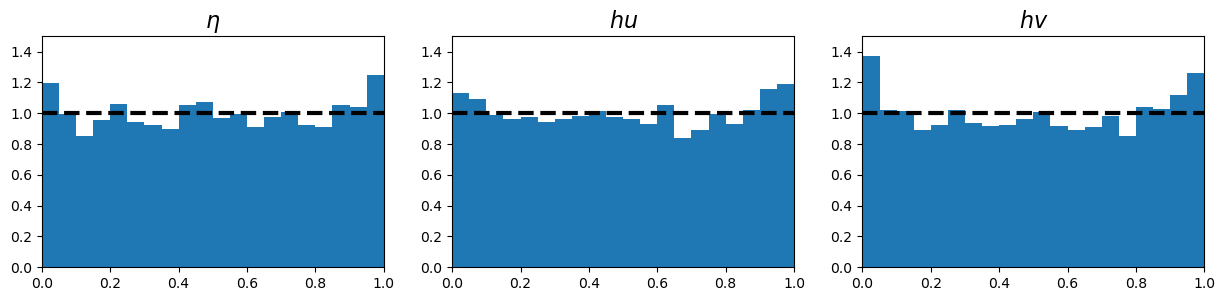

In [97]:
plot_histogram(MLranks3, bins_size=1/20, xlim=(0,1))

In [60]:
MLranks5 = 3*[np.empty(0)]

for en in range(len(exp_ns)):
    print(en)
    n = exp_ns[en]
    MLensemble = loadMLline(source_path, n)
    truth = loadTruth(source_path, n)

    for o in range(len(fine_obs_idxs)):
        for i in range(3):
            try: 
                
                cdf5 = maximal_entropyML(MLensemble, i, obs_idxs4fine[o],
                            basis=lambda n, x: eval_legendre(n,x), 
                            N=5, 
                            x=xs[i]) 

                if cdf5 is not None:
                    MLranks5[i] = np.append(MLranks5[i], getMErank(truth[i,fine_obs_idxs[o]], xs[i], cdf5))

            except:
                pass

0
1
2
3


/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

In [61]:
for i in range(3):
    print(len(MLranks5[i]))

3169
1348
4896


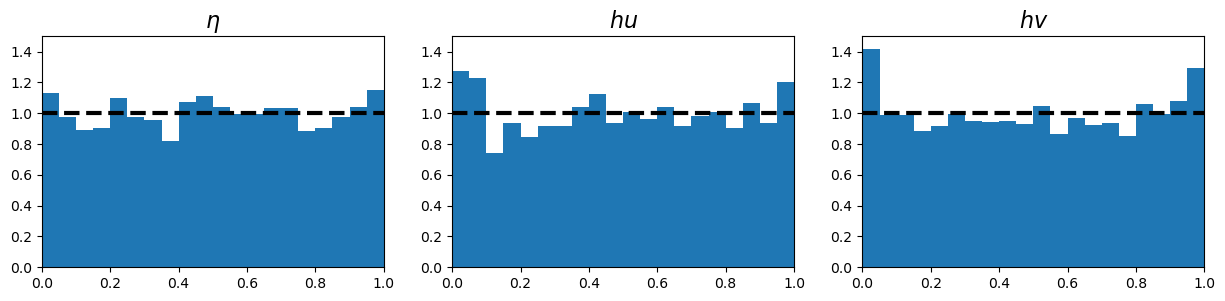

In [98]:
plot_histogram(MLranks5, bins_size=1/20, xlim=(0,1))